In [1]:
import numpy as np
import matplotlib.pyplot as plt

### `chol` Function Overview


We implement the Cholesky-Banachiewicz Algorithm:

\begin{align*}
    L_{j,j} &= \sqrt{a_{j,j} - \sum_{k=1}^{j-1}L^2_{j,k}}, \\
    L_{i,j} &= \frac{1}{L_{j,j}}(A_{i,j} - \sum_{k=1}^{j-1}L_{i,k}L_{j,k}), \quad i>j
\end{align*}

Where $L_{i,j}$ is the i,j-th entry of the lower triangular matrix obtained via Cholesky, and $A_{i,j}$ is the i,j-th entry of the matrix we want to decompose.

In [2]:
class CholUtils:
    def get_correlation(self, X, rv=True): #rv "True": rows -> variables, columns ->obs. "False" the transpose
        return np.corrcoef(X, rowvar=rv)

    def chol(self, A):
        if any(len(A) != len(row) for row in A):
            raise ValueError("Matrix is not square or the rows have wrong dimensions")
        if not np.all(np.linalg.eigvals(A) > 0):
            raise ValueError("Matrix is not positive semi-definite.")
        
        M = [[0 for _ in range(len(A[1]))] for _ in range(len(A))]
        for i in range(len(A)):
            for k in range(i + 1):
                summ = sum(M[i][j] * M[k][j] for j in range(k))
                if i == k:
                    M[k][k] = (A[k][k] - summ) ** 0.5
                else:
                    M[i][k] = (1 / M[k][k]) * (A[i][k] - summ)
        return np.array(M)
    
    def sanity_check(self, X):
        chol_check = np.linalg.cholesky(X, upper=False)
        return chol_check

    def transpose(self, A):
        return A.T

    def correlate(self, L, Z):
        if len(Z[0]) == len(L):
            print("Be careful, rows = variables, columns = observations. Transposing matrix.")
            A = self.transpose(Z)
        elif len(Z) == len(L):
            A = Z
        else:
            raise ValueError("Dimensions of L and Z are not aligned.")
        return L @ A
        #return A@L.T
    

    def generate_standard_sample(self, n, m):
        return np.random.randn(n, m)
    
    
    def plotting(self, X, title=""): #Rows->obs. Columns->variables
        plt.plot(X)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(title)
        plt.legend([f"Asset {i+1}" for i in range(X.shape[1])])
        plt.show()


cholutil = CholUtils()

### `fake_historical` Function Overview

This function generates a synthetic historical price series for a given number of time steps (`n_steps`) and assets (`n_assets`). Asset returns are drawn from a standard normal distribution, and prices are constructed using a simple random walk model.

The price at time \( t \) is given by:

$$
P_t = P_{t-1} + Y_t \quad \text{where} \quad Y_t \sim \mathcal{N}(0, 1)
$$

After generating the price paths, the function computes:
- The correlation matrix of the returns
- Its Cholesky decomposition
- The final asset prices at time \( t = \text{n\_steps} - 1 \), to be used as initial values for future simulations


In [3]:
def fake_historical(n_steps, n_assets):
    ret = cholutil.generate_standard_sample(n_steps, n_assets) #generate a matrix of normal(0,1) ret. rows->time index, column->asset
    P_0 = np.random.randint(5, 50, size=n_assets) # generate random starting prices
    prices = np.zeros((n_steps, n_assets)) #initialize the price matrix. Row->time, col->asset
    prices[0] = P_0
    for t in range(1, n_steps):
        prices[t, :] = prices[t-1, :] + ret[t, :] #simple rw P_t=P_{t-1} + Y_t, Y_t -> N(0,1)
    
    #prices = prices - np.min(prices) #ensure non negativity of prices, correlation is costants invariant
    prices = prices - np.min(prices, axis=0)
    correlation = cholutil.get_correlation(ret, False) #get the correlation of the returns
    cholesky_historical = cholutil.chol(correlation) #get the chol decomp of the returns corr. matrix
    last_price = prices[-1, :] #store last price that will be the first price of the simulated part

    return prices, correlation, cholesky_historical, last_price

### `simulated_w_correlation` Function Overview

This function generates a simulated price series with correlated asset returns, starting from a given initial price vector (`first_price`). It uses a provided Cholesky decomposition matrix (`chol`) to introduce correlation among standard normal random returns.

Uncorrelated returns are first generated from a standard normal distribution, then transformed to correlated returns using:

$$
Y_t^{\text{corr}} = L \cdot Y_t
$$

where:
- \( Y_t \sim \mathcal{N}(0, I) \) is a vector of independent returns at time \( t \)
- \( L \) is the Cholesky decomposition of a target correlation matrix

The price series is constructed using a random walk:

$$
P_t = P_{t-1} + Y_t^{\text{corr}}
$$

To ensure non-negativity, the simulated prices (excluding the initial time step) are shifted by subtracting the minimum value per asset.

The function also computes and returns the correlation matrix of the simulated (correlated) returns.



In [4]:
def simulated_w_correlation(n_steps, n_assets, first_price, chol):
    chol_matrix = chol  #get the historical chol
    ret = cholutil.generate_standard_sample(n_steps, n_assets) #generate uncorr. standard normal sample size, (#Assets, #SimulatedDay)
    correlated_ret = cholutil.correlate(chol_matrix, cholutil.transpose(ret)) #correlate the random samples(returns), we need to transose them
    correlated_ret = cholutil.transpose(correlated_ret) #
    p = np.zeros((n_steps, n_assets))
    p[0] = first_price
    for t in range(1, len(p)):
        p[t, :] = p[t-1] + correlated_ret[t, : ] #We reconstruct the price serie
    
    #p = p - np.min(p)
    p[1:, :] = p[1:, :] - np.min(p[1:, :], axis=0) #it will jump because we cant ensure that the last step of the historical is the first of the simulated AND non-negativity
    correlation = cholutil.get_correlation(correlated_ret, False)
    return p, correlation

### `demo` Function Overview

This function demonstrates the full pipeline for generating and simulating asset price paths with realistic correlations.

Given:
- `steps_hist`: number of time steps for the historical (synthetic) data
- `steps_sim`: number of time steps for the simulated future prices
- `n_as`: number of assets

The function performs the following steps:
1. **Input Validation**: Ensures all inputs are positive integers.
2. **Historical Price Generation**:
   - Calls `fake_historical()` to simulate a historical price series using a random walk with standard normal returns.
   - Retrieves the Cholesky decomposition of the historical return correlation matrix.
3. **Simulation of Correlated Prices**:
   - Uses `simulated_w_correlation()` to simulate future price paths from the last historical price, using the historical Cholesky matrix to ensure correlation structure is preserved.
4. **Sanity Check**:
   - Compares the manually computed Cholesky decomposition with NumPy’s result for validation:
   
     $$
     \text{Check:} \quad \text{Manual Cholesky} \approx \text{NumPy Cholesky}
     $$

5. **Correlation Comparison**:
   - Prints the historical correlation matrix and the correlation matrix of the simulated returns for comparison. Minor differences may arise due to:
     - Finite sample size
     - Sampling noise (returns are random samples from $\mathcal{N}(0, 1)$, not the entire distribution

6. **Plotting**:
   - Visualizes both historical and simulated price paths using `cholutil.plotting()`.

This provides a clear end-to-end view of how historical correlations can be preserved in forward-looking simulations.

Note here that the correlation of the simulation is asymptotically the same of the historical one, that is:
\begin{align*}
   C^{sim} \underset{n \to \infty}{\sim} C^{hist}
\end{align*}
where $n$ is the number of simulated days, this means that when we have a very large number of day the empirical distribution approaches the theoretical one, when we do Monte Carlo in a more accurate way we simulate millions of price paths for each assets effectively obtaining this convergence for simulated day.



Sanity check of the Historical Chol Decomp: 
 Manually computed Chol: 
 [[ 1.      0.      0.    ]
 [ 0.0102  0.9999  0.    ]
 [-0.0239 -0.012   0.9996]] 
 Cholesky with numpy: 
 [[ 1.      0.      0.    ]
 [ 0.0102  0.9999  0.    ]
 [-0.0239 -0.012   0.9996]]

 ************************************************** 
 The Hist. corr matrix is: 
 [[ 1.      0.0102 -0.0239]
 [ 0.0102  1.     -0.0123]
 [-0.0239 -0.0123  1.    ]]

 ************************************************** 
 The correlation of the simulated (should be very similiar to the historical): 
 [[ 1.      0.0104 -0.0238]
 [ 0.0104  1.     -0.0123]
 [-0.0238 -0.0123  1.    ]]


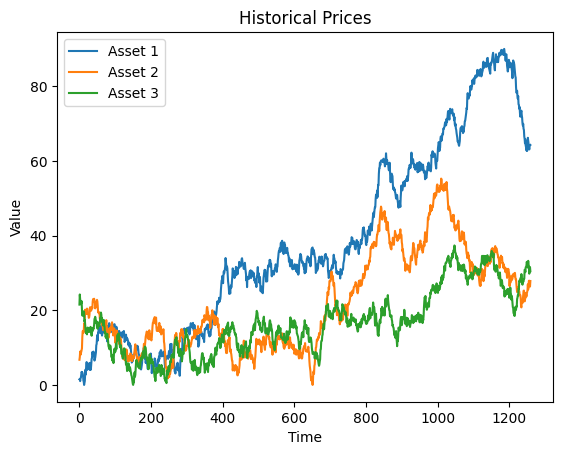

C:\Users\gabri\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


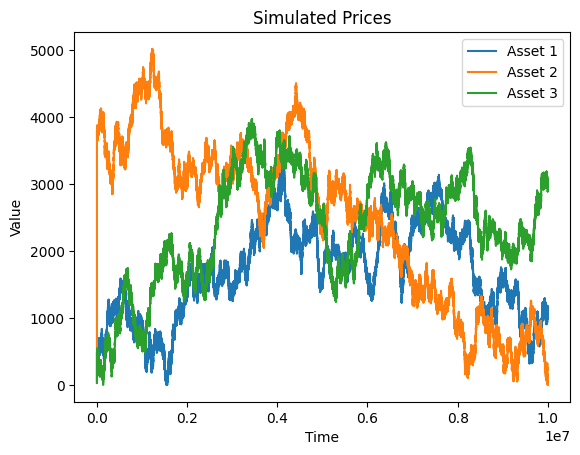

In [6]:
def demo(steps_hist, steps_sim, n_as):
    if steps_hist <= 0 or steps_sim <= 0 or n_as <= 0:
        raise ValueError("All input parameters must be positive integers.")
    
    hist_prices, hist_corr, hist_chol, hist_last_price = fake_historical(steps_hist, n_as)
    sim_prices, sim_corr = simulated_w_correlation(steps_sim, n_as, hist_last_price, hist_chol)
    sanity_check = cholutil.sanity_check(hist_corr)
    print("Sanity check of the Historical Chol Decomp: \n", f"Manually computed Chol: \n {hist_chol.round(4)} \n", f"Cholesky with numpy: \n {sanity_check.round(4)}")
    print("\n", "*"*50, "\n", f"The Hist. corr matrix is: \n {hist_corr.round(4)}")
    print("\n", "*"*50, "\n", f"The correlation of the simulated (should be very similiar to the historical): \n {sim_corr.round(4)}") 
    # the difference in the 2 matrix is due to: Finite sample size, 
    # sampling noise: each obs is just 1 sample of N(0,1) not all theoretical distribution,

    cholutil.plotting(hist_prices, "Historical Prices")

    cholutil.plotting(sim_prices, "Simulated Prices")


demo(252*5, 10000000, 3) #the more we increase steps_sim the more the method is accurate, 
                       #when we do real Monte Carlo, we sample millions of time for the same process, this is just a proof of concept.